Date: 2020/10/15 <br/>
Author: Kemeng Liu

This script is to be submitted as final project for the course MET_Spatial_Python.

The idea of this project is to go through a workflow of deriving stream/basin related morpological parameters/index from a Digital Elevation Model (DEM) by integrating needed tools into python, so that the whole workflow is executed in python.

The Workflow is divided into three parts:
1. The DEM was got using Google Earth Engine Python API; The Polygon of the basin was downloaded manually.

2. The DEM was reprojected and clipped to the geometry of the basin.

3. The morpological parameters was calculated by interacting with GRASS GIS.

However, to make it possible automatizing this workflow, there are still some problems to be solved:
* each of the three parts analysis was done in separate python environment in this project ~ they need to be united. 

* The geometry of basins could also be accessed via Earth Engine; but how to export it within python session still needs some exploring.

* The GRASS Addon 'r.basin' is able to derived many advanced morporlogical parameters, but it's quite buggy...i'm still looking for solution.

Outputs of Part-1 and Part-2 are located in the folder 'data', while a few outputs from 'r.basin' are located in the folder 'output'.

## Part_1. Get DEM using Earth Engine Python API

In [1]:
import os
import ee
import numpy as np
import matplotlib.pyplot as plt
import gdal
import osr
import time

In [2]:
os.chdir("C:/EAGLE/MET_Python/final_project/data")
os.getcwd()

'C:\\EAGLE\\MET_Python\\final_project\\data'

In [3]:
# Initialize earth engine api
ee.Initialize()

In [39]:
# Load HydroSHEDS Hydrologically Conditioned DEM, 3 Arc-Seconds
hydroDEM = ee.Image('WWF/HydroSHEDS/03CONDEM')
hydroDEM

In [40]:
# Define a bounding box of the basin of interest
basin_bbox = ee.Geometry.Polygon(
        [[[104.64983742110468, 18.085162799249574],
          [104.64983742110468, 17.511144981641994],
          [105.13735573165155, 17.511144981641994],
          [105.13735573165155, 18.085162799249574],
          [104.64983742110468, 18.085162799249574]]])

#basin_bbox = ee.Geometry.Polygon(
#          [[[104.64983742110468, 18.085162799249574],
#          [104.64983742110468, 17.511144981641994],
#          [105.13735573165155, 17.511144981641994],
#          [105.13735573165155, 18.085162799249574],
#          [104.64983742110468, 18.085162799249574]]])

In [41]:
# Clip DEM with basin as mask
hydroDEM_clip = hydroDEM.clip(basin_bbox).select("b1")

In [42]:
# Get the band Latitude and Longitude
latlon = ee.Image.pixelLonLat().addBands(hydroDEM_clip)

# Reduce the bands to list
latlon = latlon.reduceRegion(reducer=ee.Reducer.toList(),
                             geometry=basin_bbox,
                             maxPixels=1e10,
                             scale=90)

In [43]:
# Convert the lists to numpy array
elev = np.array((ee.Array(latlon.get("b1")).getInfo()))
lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))

In [44]:
uniqueLats = np.unique(lats)
uniqueLons = np.unique(lons)

# Determine pixelsizes
ys = uniqueLats[1] - uniqueLats[0]
xs = uniqueLons[1] - uniqueLons[0]

# Determine Imgage Origin (Upper left)
y0 = uniqueLats.max()
x0 = uniqueLons.min()

# Determine nrow and ncolumn
nrows = len(uniqueLats)
ncols = len(uniqueLons)

print("Pixels sizes are: ", ys, xs)
print("Upper left origin is: ", y0, x0)
print("nrow and ncol of the raster is: ", nrows, ncols)

Pixels sizes are:  0.0008084837557085223 0.0008084837557049696
Upper left origin is:  18.084568889544766 104.65054158066563
nrow and ncol of the raster is:  710 603


In [45]:
# Create an array with dimension of the image
arr = np.zeros([nrows, ncols], np.float32)

In [46]:
# Fill the array with values
counter =0
for y in range(0,len(arr),1):
    for x in range(0,len(arr[0]),1):
        if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
            counter+=1
            # start from lower left corner
            arr[len(uniqueLats)-1-y,x] = elev[counter] 

IndexError: index 428125 is out of bounds for axis 0 with size 428125

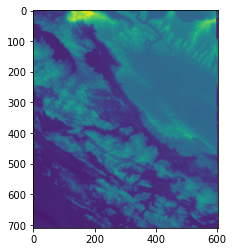

In [47]:
# Plot the image
plt.imshow(arr)
plt.show()

In [48]:
# Set Transformer
# ((oringinX, pixelWidth, 0, originY, 0, pixelHeight))
transform = (x0, xs, 0, y0, 0, -ys)

In [49]:
# Set the Coordinate System
target = osr.SpatialReference()
target.ImportFromEPSG(4326)

0

In [50]:
# Set driver
driver = gdal.GetDriverByName('GTiff')

timestring = time.strftime("%Y%m%d_%H%M%S")

output = driver.Create("hydroDEM.tif", ncols, nrows, 1, gdal.GDT_Float32)

In [51]:
# Add some metadata
output.SetMetadata({'time': str(timestring)})
output.SetGeoTransform(transform)
output.SetProjection(target.ExportToWkt())
output.GetRasterBand(1).WriteArray(arr)
output.GetRasterBand(1).SetNoDataValue(-9999)
output = None

## Part_2. Pre-process DEM (reproject & masked to basin)

In [1]:
import os
import numpy as np
import geopandas as gpd
import rasterio

from rasterio.plot import show, plotting_extent
from rasterio.mask import mask
from rasterio.merge import merge

In [2]:
os.chdir('C:/EAGLE/MET_Python/final_project/data')
os.getcwd()

'C:\\EAGLE\\MET_Python\\final_project\\data'

### Reproject DEM

In [4]:
path_dem = os.path.join(os.getcwd(), 'hydroDEM.tif')

hydroDEM = rasterio.open(path_dem)

print(hydroDEM.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 603, 'height': 710, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008084837557049696, 0.0, 104.65054158066563,
       0.0, -0.0008084837557085223, 18.084568889544766)}


In [9]:
# Define function to reproject Raster
def reproject_raster(in_path, out_path, dst_crs):
    
    with rasterio.open(path_dem) as src:
        transform, width, height = rasterio.warp.calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
    
        with rasterio.open(path_dem_prj, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                rasterio.warp.reproject(
                    source = rasterio.band(src, i),
                    destination = rasterio.band(dst, i),
                    src_transform = src.transform,
                    src_crs = src.crs,
                    dst_transform = transform,
                    dst_crs = dst_crs,
                    resampling = rasterio.warp.Resampling.nearest)
    return(out_path)

In [10]:
# WGS 84 / UTM zone 48N
dst_crs = 'EPSG:32648'

path_dem = os.path.join(os.getcwd(), 'hydroDEM.tif')
path_dem_prj = os.path.join(os.getcwd(), 'hydroDEM_prj.tif')

# Reproject
reproject_raster(path_dem, path_dem_prj, dst_crs)

'C:\\EAGLE\\MET_Python\\final_project\\data\\hydroDEM_prj.tif'

In [11]:
path_dem_prj = os.path.join(os.getcwd(), 'hydroDEM_prj.tif')
hydroDEM_prj = rasterio.open(path_dem_prj)
print(hydroDEM_prj.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 589, 'height': 723, 'count': 1, 'crs': CRS.from_epsg(32648), 'transform': Affine(87.88967373508459, 0.0, 462904.50956110685,
       0.0, -87.88967373508459, 1999576.9614275643)}


### Reproject Basin Polygon

In [12]:
# Import Vector
path_basin = os.path.join(os.getcwd(), 'basin.geojson')

basin = gpd.read_file(path_basin)

In [14]:
basin.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
# Reproject to WGS 84 / UTM zone 48N
basin_prj = basin.to_crs(hydroDEM_prj.crs)

basin_prj.crs

<Projected CRS: EPSG:32648>
Name: WGS 84 / UTM zone 48N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 48N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
# Write Vector
basin_prj.to_file("basin_prj.shp")

In [18]:
# Convert Geometry of the 'shp' into JSON Format, 
# so that rasterio can read it
def getFeatures(gdf):
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [20]:
coords = getFeatures(basin_prj)
#print(coords)

### Mask DEM by Basin

In [21]:
# Load DEM
path_dem_prj = os.path.join(os.getcwd(),'hydroDEM_prj.tif')
hydroDEM_prj = rasterio.open(path_dem_prj)

In [22]:
print('Raster Bounds is ', hydroDEM_prj.bounds, '\n')
print('Pixel resolution is ', hydroDEM_prj.res)

Raster Bounds is  BoundingBox(left=462904.50956110685, bottom=1936032.727317098, right=514671.52739107166, top=1999576.9614275643) 

Pixel resolution is  (87.88967373508459, 87.88967373508459)


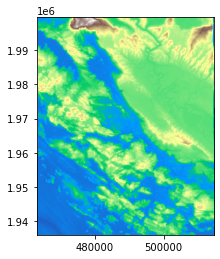

<AxesSubplot:>

In [24]:
show(hydroDEM_prj, cmap="terrain", transform=hydroDEM_prj.transform)

In [25]:
# Clip Raster with Vector Mask
out_img, out_transform = mask(dataset=hydroDEM_prj, shapes=coords, crop=True)

In [28]:
hydroDEM_clip = np.ma.masked_array(out_img, mask=(out_img <= 0))
type(hydroDEM_clip)

numpy.ma.core.MaskedArray

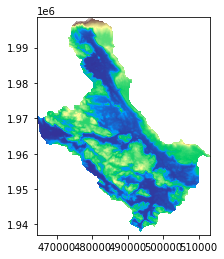

<AxesSubplot:>

In [29]:
show(hydroDEM_clip, cmap="terrain", transform=out_transform)

In [30]:
hydroDEM_clip.shape

(1, 699, 558)

### Export masked DEM

In [31]:
# Copy Metadata of oringinal Raster
out_meta = hydroDEM_prj.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 589, 'height': 723, 'count': 1, 'crs': CRS.from_epsg(32648), 'transform': Affine(87.88967373508459, 0.0, 462904.50956110685,
       0.0, -87.88967373508459, 1999576.9614275643)}


In [32]:
out_meta.update({
    "driver": "GTiff",
    "count": hydroDEM_clip.shape[0],
    "height": hydroDEM_clip.shape[1],
    "width": hydroDEM_clip.shape[2],
    "transform": out_transform,
    "crs": hydroDEM_prj.crs
})

In [33]:
# Write Cliped Raster to Disk
with rasterio.open("hydroDEM_clip.tif", "w", **out_meta) as dest:
    dest.write(hydroDEM_clip)

## Part_3. Calculate Some Morphological Parameters of the Basin using GRASS GIS

In [1]:
import os
import sys
import subprocess
import shutil
import binascii
import tempfile

from grass_session import Session
import grass.script as gs
import grass.script.setup as gsetup

import numpy as np
import matplotlib
import wx

In [12]:
os.chdir('/home/shirobakaidou/eagle/MET_Spatial_Python/grass')
os.getcwd()

'/home/shirobakaidou/eagle/MET_Spatial_Python/grass'

In [21]:
# Define GRASS Database
dbase = os.getcwd()
location = 'mylocation'

# Set GISBASE environment variable
gisbase = '/usr/lib/grass78'
os.environ['GISBASE'] = str(gisbase)

# Initialize
gsetup.init(os.environ['GISBASE'], dbase, location, 'PERMANENT')

print(gs.gisenv())

{'GISDBASE': '/home/shirobakaidou/eagle/MET_Spatial_Python/grass', 'LOCATION_NAME': 'mylocation', 'MAPSET': 'PERMANENT'}


In [25]:
# Create Location
gs.create_location(dbase, location)

In [27]:
# Create a new location, using a georeferenced file
gs.run_command('g.proj', flags="c",
               georef="/home/shirobakaidou/eagle/MET_Spatial_Python/data/hydroDEM_clip.tif",
               location="location_vietnam")

Location <location_vietnam> created
You can switch to the new location by
`g.mapset mapset=PERMANENT location=location_vietnam`


0

In [28]:
# Switch to the location_vietnam, mapset "PERMANENT"
gs.run_command('g.mapset', 
               location="location_vietnam",
               mapset="PERMANENT")

Mapset switched. Your shell continues to use the history for the old mapset
You can switch the history by commands:
history -w; history -r
/home/shirobakaidou/eagle/MET_Spatial_Python/grass/location_vietnam/PERMANENT/.bash_history;
HISTFILE=/home/shirobakaidou/eagle/MET_Spatial_Python/grass/location_vietnam/PERMANENT/.bash_history


0

In [30]:
# Display CRS Info
gs.run_command('g.proj', flags="p")

-PROJ_INFO-------------------------------------------------
name       : WGS 84 / UTM zone 48N
datum      : wgs84
ellps      : wgs84
proj       : utm
zone       : 48
no_defs    : defined
-PROJ_EPSG-------------------------------------------------
epsg       : 32648
-PROJ_UNITS------------------------------------------------
unit       : meter
units      : meters
meters     : 1


0

In [46]:
# Read GeoTiFF as GRASS Raster (Import Raster)
gs.run_command('r.in.gdal', 
               #flags='e', # update the default region
               input='/home/shirobakaidou/eagle/MET_Spatial_Python/data/hydroDEM_clip.tif',
               output='elevation', 
               overwrite=True)

Importing raster map <elevation>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


0

In [48]:
# Set Region
gs.run_command('g.region', 
               flags="pa",
               raster='elevation')

projection: 1 (UTM)
zone:       48
datum:      wgs84
ellipsoid:  wgs84
north:      1998522.28534274
south:      1937087.40340192
west:       464222.85466713
east:       513265.29261131
nsres:      87.88967374
ewres:      87.88967374
rows:       699
cols:       558
cells:      390042


0

In [44]:
# Install hydrology related GRASS Addons

#gs.run_command('g.extension', extension='r.basin', operation='add')
#gs.run_command('g.extension', extension='r.hypso', operation='add')
#gs.run_command('g.extension', extension='r.stream.basins', operation='add')
#gs.run_command('g.extension', extension='r.stream.distance', operation='add')
#gs.run_command('g.extension', extension='r.stream.order', operation='add')
#gs.run_command('g.extension', extension='r.stream.snap', operation='add')
#gs.run_command('g.extension', extension='r.stream.stats', operation='add')
#gs.run_command('g.extension', extension='r.width.funct', operation='add')
#gs.run_command('g.extension', extension='r.stream.channel', operation='add')
#gs.run_command('g.extension', extension='r.stream.segment', operation='add')
#gs.run_command('g.extension', extension='r.stream.slope', operation='add')

In [40]:
# Define Threshold:
# source: https://github.com/OSGeo/grass-addons/blob/master/grass7/raster/r.basin/r.basin.py
resolution = gs.region()['nsres']
th = 1000000 / (resolution**2)
gs.message( "threshold : %s" % th )

threshold : 129.45662942175616


In [49]:
# Calculates raster map of accumulation, flow direction, stream network and basin.
gs.run_command('r.watershed',
               elevation='elevation',
               accumulation='accum', # output accumulation (raster)
               drainage='direction', # output flow direction (raster)
               stream='streams',  # output stream segments/network (raster)
               basin='basin', # output basin (raster)
               threshold=th,
               overwrite=True)

SECTION 1a (of 5): Initiating Memory.
SECTION 1b (of 5): Determining Offmap Flow.
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
SECTION 2: A* Search.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 3a: Accumulating Surface Flow with MFD.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
SECTION 3b: Adjusting drainage directions.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
SECTION 4: Watershed determination.
   0   2   4   6   8  10  12  14  16  18  20  22 

0

In [50]:
# Calculates Strahler's and Horton's hierarchy
gs.run_command('r.stream.order',
               stream_rast='streams', # input
               direction='direction', # input
               strahler='riveroder_strahler', # output Strahler's stream order
               horton='riverorder_horton', # output Horton's stream order
               overwrite=True)

Memory swap calculation (may take some time)...
Reading raster map <streams>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading raster map <direction>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Finding nodes...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Finding longest streams...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Calculating Strahler's stream order...
Calculating Hortons's stream order...


0

In [51]:
# Calculates Horton's statistics for Strahler and Horton ordered stream networks
gs.run_command('r.stream.stats',
               stream_rast='riverorder_horton',
               direction='direction',
               elevation='elevation')


Summary:
Max order | Tot.N.str. | Tot.str.len. | Tot.area. | Dr.dens. | Str.freq. 
  (num)   |    (num)   |     (km)     |   (km2)   | (km/km2) | (num/km2) 
        5 |        250 |     694.2331 | 1160.9216 |   0.5980 |  0.2153 

Stream ratios based on regression coefficient:
 Bif.rt. | Len.rt. | Area.rt. | Slo.rt. | Grd.rt. 
  3.3872 |  2.4665 |   3.6855 |  1.7301 |  1.7977

Averaged stream ratios with standard deviations:
 Bif.rt. | Len.rt. | Area.rt. | Slo.rt. | Grd.rt. 
  3.7848 |  2.6789 |   2.8526 |  1.7186 |  1.8166
  2.2647 |  0.8450 |   2.0084 |  0.2522 |  0.4176

Order | Avg.len |  Avg.ar  |  Avg.sl |  Avg.grad. | Avg.el.dif
 num  |   (km)  |  (km2)   |  (m/m)  |    (m/m)   |     (m)   
    1 |  1.1575 |   2.5532 |  0.0780 |     0.0654 | 83.6755
    2 |  4.0625 |   9.8660 |  0.0490 |     0.0485 | 184.4444
    3 | 12.1303 |  45.0130 |  0.0307 |     0.0306 | 338.6923
    4 | 18.3672 | 134.3075 |  0.0146 |     0.0138 | 288.5000
    5 | 49.6965 | 470.5553 |  0.0092 |     0.0065 

Memory swap calculation (may take some time)...
Reading raster map <riverorder_horton>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading raster map <direction>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading raster map <elevation>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


0

In [52]:
# Calculates a bunch of advanced morphological parameters of river basin
gs.run_command('r.basin',
               map = 'elevation',
               #flags="c",
               prefix = 'basin_param', # output prefix
               coord = ("490282.15625,1966838"), # east,north of the outlet point
               dir = '/home/shirobakaidou/eagle/MET_Spatial_Python/output', # Directory of the output
               threshold = th,
               overwrite=True)

SECTION 1 beginning: Initiating Variables. 4 sections total.
SECTION 1a: Mark masked and NULL cells
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 1b: Determining Offmap Flow.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 2: A* Search.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 3a: Accumulating Surface Flow with MFD.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  

Tot. cells 34076.0
Hypsometric | quantiles
1122 | 0.025
962 | 0.05
766 | 0.1
622 | 0.25
419 | 0.5
229 | 0.75
186 | 0.9
176 | 0.975


Done!


------------------------------
------------------------------
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Gtk-Message: 22:40:08.072: Failed to load module "atk-bridge"
Gtk-Message: 22:40:08.074: Failed to load module "canberra-gtk-module"


Tot. cells 34076.0
Tot. area 263223290.7052134
Max distance 48721.780628
Width Function | quantiles
4946 | 0.05
13646 | 0.15
21509 | 0.3
28104 | 0.4
31618 | 0.5
34673 | 0.6
37616 | 0.7
43179 | 0.85
45632 | 0.95


Done!


------------------------------
Calculating segments in direction <DOWNSTREAM> (may take some time)...
Reading raster map <basin_param_elevation_stream_e>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading raster map <basin_param_elevation_drainage>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Finding nodes...
Reading raster map <r_elevation_crop>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Calculate downstream parameters...
   0   2   5   8  11  14  17  20  22  25  28  31  34  37  40  42  45  48  51  54  57  60  62  65  68  71  74  77  80  82  85  88  91  94  97 100
Writing raster map <basin_param_elevation_hillslope_distance>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  

0